#### In the notebook below, we import our data from the Reddit API. Then we run some initial EDA to understand the most common words, highest coefficients, and nature of the threads.

#### We then built an initial LR model and after that removed some high signal words using a modified stop word list. We then used a variety of models to improve on this and hyperparameter optimised, ultimately arriving at SVM.

In [476]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn import datasets
from sklearn.svm import SVC

### 1) Importing our data from earlier API calls

Note that the PRAW wrapper allows for only ~1000 posts per day, so I built this data over a few days. See Reddit_API_datapull.ipynb for mode information

In [477]:
df_chat = pd.read_csv('df_chatgpt_total.csv')
df_chat.head()

,Unnamed: 0.1,Unnamed: 0,title,selftext,subreddit,score,created_utc,name,id,comments
0,0,0.0,ChatGPT for work in company that banned ChatGP...,"Hi all, am sure many here like myself work for...",ChatGPT,1.0,19c7niu,t3_19c7niu,19c7niu,**Attention! [Serious] Tag Notice**\n\n : Joke...
1,1,1.0,Evolution Series #122: Meerkat,NaN,ChatGPT,1.0,19c7kv5,t3_19c7kv5,19c7kv5,Hey /u/Parking_Ad5541!\n\nIf your post is a sc...
2,2,2.0,ChatGPT is an arrogant rapper,"ChatGPT is getting a big head:\n\nBehold, I am...",ChatGPT,1.0,19c76zn,t3_19c76zn,19c76zn,Hey /u/Parking_Ad5541!\n\nIf your post is a sc...
3,3,3.0,An Amazing Tool for Writers,"I write a daily blog on Bible study topics, an...",ChatGPT,2.0,19c71l9,t3_19c71l9,19c71l9,Hey /u/bsprad49!\n\nIf your post is a screensh...
4,4,4.0,Future Hobbits,NaN,ChatGPT,9.0,19c6nf5,t3_19c6nf5,19c6nf5,Hey /u/futureformsdance!\n\nIf your post is a ...


In [478]:
df_mid = pd.read_csv('df_midjourney_total.csv')
df_mid.head()

,Unnamed: 0.1,Unnamed: 0,title,selftext,subreddit,score,created_utc,name,id,comments
0,0,0,"Hi, could you guys tell me if this is AI gener...",NaN,midjourney,1.0,19c7xex,t3_19c7xex,19c7xex,NaN
1,1,1,Painting 5,"painting by Ilya repin, Japanese vampire princ...",midjourney,1.0,19c7v3l,t3_19c7v3l,19c7v3l,NaN
2,2,2,Painting 4,"\npainting by Ilya repin oil on canvas , Malay...",midjourney,3.0,19c7js0,t3_19c7js0,19c7js0,NaN
3,3,3,Painting 3,"\npainting by edward hopper oil on canvas, qin...",midjourney,4.0,19c7j43,t3_19c7j43,19c7j43,NaN
4,4,4,BREAKING LEGOS,[DanielGindin.com](https://DanielGindin.com),midjourney,1.0,19c7fbp,t3_19c7fbp,19c7fbp,NaN


Merging both datasets

In [479]:
df = pd.concat([df_chat,df_mid])
df.head()

,Unnamed: 0.1,Unnamed: 0,title,selftext,subreddit,score,created_utc,name,id,comments
0,0,0.0,ChatGPT for work in company that banned ChatGP...,"Hi all, am sure many here like myself work for...",ChatGPT,1.0,19c7niu,t3_19c7niu,19c7niu,**Attention! [Serious] Tag Notice**\n\n : Joke...
1,1,1.0,Evolution Series #122: Meerkat,NaN,ChatGPT,1.0,19c7kv5,t3_19c7kv5,19c7kv5,Hey /u/Parking_Ad5541!\n\nIf your post is a sc...
2,2,2.0,ChatGPT is an arrogant rapper,"ChatGPT is getting a big head:\n\nBehold, I am...",ChatGPT,1.0,19c76zn,t3_19c76zn,19c76zn,Hey /u/Parking_Ad5541!\n\nIf your post is a sc...
3,3,3.0,An Amazing Tool for Writers,"I write a daily blog on Bible study topics, an...",ChatGPT,2.0,19c71l9,t3_19c71l9,19c71l9,Hey /u/bsprad49!\n\nIf your post is a screensh...
4,4,4.0,Future Hobbits,NaN,ChatGPT,9.0,19c6nf5,t3_19c6nf5,19c6nf5,Hey /u/futureformsdance!\n\nIf your post is a ...


In [480]:
df.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'], inplace = True)

Converting 'subreddit' to 1/0 for logistic regression

In [481]:
df['subreddit'] = np.where(df['subreddit'] == 'ChatGPT', 1, 0)
df.head()

,title,selftext,subreddit,score,created_utc,name,id,comments
0,ChatGPT for work in company that banned ChatGP...,"Hi all, am sure many here like myself work for...",1,1.0,19c7niu,t3_19c7niu,19c7niu,**Attention! [Serious] Tag Notice**\n\n : Joke...
1,Evolution Series #122: Meerkat,NaN,1,1.0,19c7kv5,t3_19c7kv5,19c7kv5,Hey /u/Parking_Ad5541!\n\nIf your post is a sc...
2,ChatGPT is an arrogant rapper,"ChatGPT is getting a big head:\n\nBehold, I am...",1,1.0,19c76zn,t3_19c76zn,19c76zn,Hey /u/Parking_Ad5541!\n\nIf your post is a sc...
3,An Amazing Tool for Writers,"I write a daily blog on Bible study topics, an...",1,2.0,19c71l9,t3_19c71l9,19c71l9,Hey /u/bsprad49!\n\nIf your post is a screensh...
4,Future Hobbits,NaN,1,9.0,19c6nf5,t3_19c6nf5,19c6nf5,Hey /u/futureformsdance!\n\nIf your post is a ...


In [482]:
df.reset_index(drop=True, inplace=True)

In [483]:
df.tail()

,title,selftext,subreddit,score,created_utc,name,id,comments
3345,Sausage men,NaN,0,NaN,19etviu,t3_19etviu,NaN,NaN
3346,A plea for help! I was designing my wedding in...,"hello all, I designed some artwork for my wedd...",0,NaN,19etpkq,t3_19etpkq,NaN,NaN
3347,Four eyes,Asked MJ for a portrait of a person with FOUR ...,0,NaN,19etp56,t3_19etp56,NaN,NaN
3348,Is this good quality ?,NaN,0,NaN,19etidw,t3_19etidw,NaN,NaN
3349,1940s Star Wars,NaN,0,NaN,19etatt,t3_19etatt,NaN,NaN


### 2) Cleaning and EDA
First, establishing a baseline, doing a train test split, then count vectorizing and removing common stop words as these offer little value to the model

In [484]:
X = df['title']
y = df['subreddit']

Let's establish a baseline, which is essentially always predicting the majority class. This is 60.4%

In [485]:
y.value_counts(normalize=True)

0    0.604478
1    0.395522
Name: subreddit, dtype: float64

In [486]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [487]:
cvec = CountVectorizer(stop_words = 'english')

In [488]:
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [489]:
X_train_cvec = cvec.transform(X_train)

In [490]:
X_test_cvec = cvec.transform(X_test)

Now let's look for the most common words in the combined dataframe to see if this gives us some initial insight

In [491]:
X_train_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names())

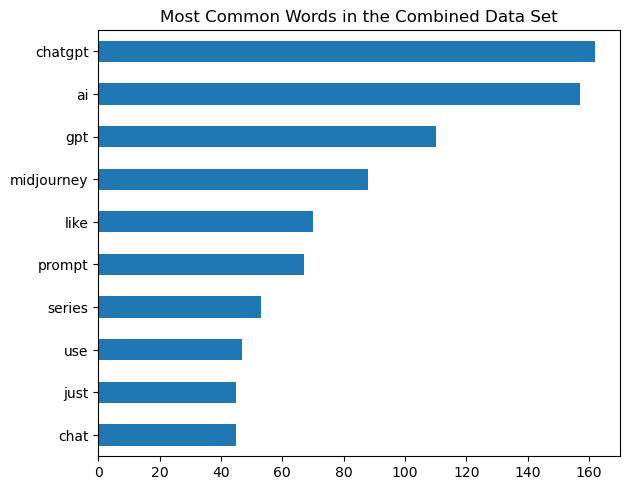

In [528]:
X_train_df.sum().sort_values().tail(10).plot(kind='barh')
plt.savefig('most_common_df_words_1.png')
plt.tight_layout()
plt.title('Most Common Words in the Combined Data Set')
plt.show()

We can see some words like 'chatgpt' and 'midjourney', which will likely have very high feature coefficients, so we will probably want to remove them later

Let's examine this for each individual subreddit

In [493]:
df_chat = df_chat.drop(columns = 'Unnamed: 0')
df_chat['subreddit'] = np.where(df_chat['subreddit'] == 'ChatGPT', 1, 0)
X = df_chat['title']
y = df_chat['subreddit']
X_train_chat, X_test_chat, y_train_chat, y_test_chat = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(X_train_chat)
X_train_chat = cvec.transform(X_train_chat)
X_train_df_chat = pd.DataFrame(X_train_chat.todense(), columns=cvec.get_feature_names())

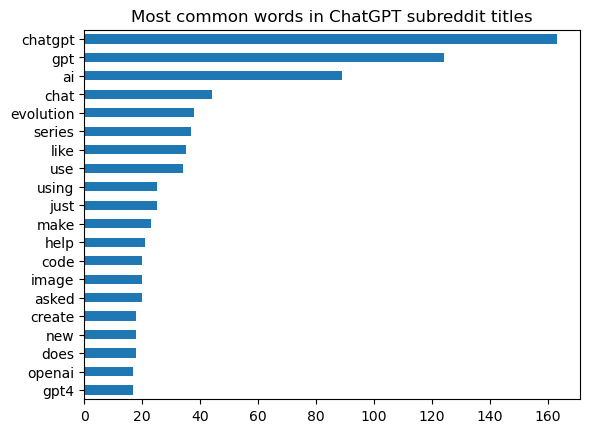

In [494]:
chat_words = X_train_df_chat.sum().sort_values().tail(20)
ax = chat_words.plot(kind='barh')
ax.set_title('Most common words in ChatGPT subreddit titles')
plt.show()

In [495]:
df_mid = df_mid.drop(columns = 'Unnamed: 0')
df_mid['subreddit'] = np.where(df_mid['subreddit'] == 'midGPT', 1, 0)
X = df_mid['title']
y = df_mid['subreddit']
X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(X_train_mid)
X_train_mid = cvec.transform(X_train_mid)
X_train_df_mid = pd.DataFrame(X_train_mid.todense(), columns=cvec.get_feature_names())

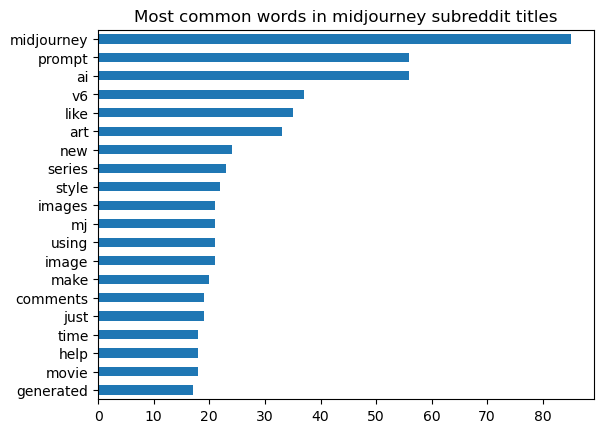

In [497]:
mid_words = X_train_df_mid.sum().sort_values().tail(20)
ax = mid_words.plot(kind='barh')
ax.set_title('Most common words in midjourney subreddit titles');

But before we remove these high signal words, let's run a basic logistic regression model to see how good our model would be on raw titles alone, using only full words as features.

In [498]:
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

cvec = CountVectorizer(stop_words='english',token_pattern=r'\b[a-zA-Z]+\b')
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [499]:
logreg = LogisticRegression()
logreg.fit(X_train_cvec, y_train)
print(f'Training Score: {logreg.score(X_train_cvec, y_train)}, Test Score: {logreg.score(X_test_cvec, y_test)}')



Training Score: 0.9442959001782532, Test Score: 0.8146473779385172


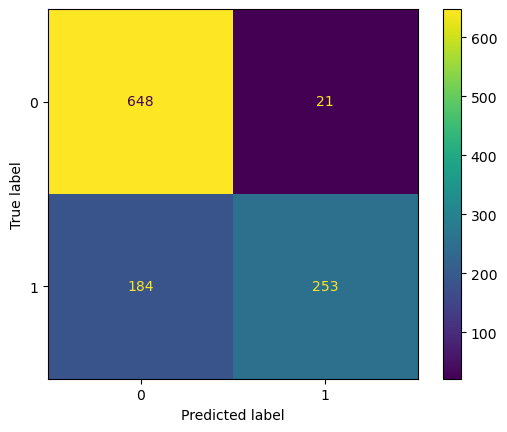

In [500]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_cvec, y_test);

In [501]:
preds = logreg.predict(X_test_cvec)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [506]:
preds = logreg.predict(X_test_cvec)

def find_cm(y_test, preds):
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    sensitivity = tp/(tp+fn)
    
    specificity = tn / (tn + fp) # this is also called recall
    
    precision = tp / (tp+ fp)
    
    f1 = 2* (precision * specificity) / (precision + specificity)
    
    
    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
    
    print(f"Sensitivity: {tp/(tp+fn)}\nSpecificity: {tn/(tn+fp)}\nPrecision: {precision}\nf1: {f1}")
find_cm(y_test, preds)

TN: 648
FP: 21
FN: 184
TP: 253
Sensitivity: 0.5789473684210527
Specificity: 0.968609865470852
Precision: 0.9233576642335767
f1: 0.9454425923202685


The model is heavily overfit. It also has low sensitivity and high specificity ie it misclassifies many ChatGPT posts as Midjourney, but if it classifies it as ChatGPT it is very likely right. I have also calculated f1 score, which is the harmonic mean of precision (how accurate are the positives ie tp/tp+fp, rewarding low false positives) and specificity or recall which is how good the model is at finding positives, rewarding false negatives (tp/tp+fn).

Let's see how adding post content affects this

In [507]:
df['all_text'] = df['title'] + ', ' + df['selftext']
df['all_text'].head()

0    ChatGPT for work in company that banned ChatGP...
1                     Evolution Series #122: Meerkat, 
2    ChatGPT is an arrogant rapper, ChatGPT is gett...
3    An Amazing Tool for Writers, I write a daily b...
4                                     Future Hobbits, 
Name: all_text, dtype: object

In [508]:
# removing NaNs
df['selftext'] = df['selftext'].fillna("")
df['selftext'].head()

0    Hi all, am sure many here like myself work for...
1                                                     
2    ChatGPT is getting a big head:\n\nBehold, I am...
3    I write a daily blog on Bible study topics, an...
4                                                     
Name: selftext, dtype: object

In [509]:
df['all_text'] = df['title'] + ', ' + df['selftext']
df['all_text'].head()

0    ChatGPT for work in company that banned ChatGP...
1                     Evolution Series #122: Meerkat, 
2    ChatGPT is an arrogant rapper, ChatGPT is gett...
3    An Amazing Tool for Writers, I write a daily b...
4                                     Future Hobbits, 
Name: all_text, dtype: object

Now using titles and posts as our feature set. I used a test size of 33%. This is quite high but we are dealing with a relatively small dataset of around 3000 posts, so I wanted to ensure there was enough test data.

In [510]:
X = df['all_text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

cvec = CountVectorizer(stop_words='english',token_pattern=r'\b[a-zA-Z]+\b')
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [511]:
logreg = LogisticRegression()
logreg.fit(X_train_cvec, y_train)
print(f'Training Score: {logreg.score(X_train_cvec, y_train)}, Test Score: {logreg.score(X_test_cvec, y_test)}')


Training Score: 0.9536541889483066, Test Score: 0.8417721518987342


In [512]:
preds = logreg.predict(X_test_cvec)
find_cm(y_test, preds)

TN: 650
FP: 19
FN: 156
TP: 281
Sensitivity: 0.6430205949656751
Specificity: 0.9715994020926756
Precision: 0.9366666666666666
f1: 0.9538132948988091


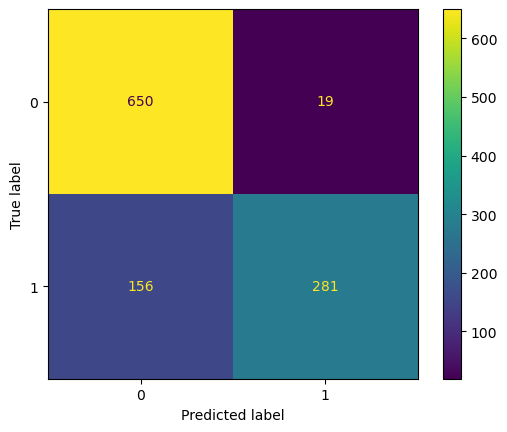

In [513]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_cvec, y_test);

Unsurprisingly, this is an improvement across all our metrics. But the model is still overfit and has relatively low sensitivity, ie it misclassifies many ChatGPT posts as Midjourney.

At this point, we will remove the most obvious feature words ('Chat GPT', 'midjourney' etc) to see how the model performs. We originally listed the most common words, but let's look at the coeffcients from the LR to see what is having the greatest impact.

In [514]:
feature_names = cvec.get_feature_names()
coefficients = logreg.coef_[0]
feature_coefficients = pd.DataFrame({'Feature': feature_names, 'Coef': coefficients})
feature_coefficients.set_index('Feature', inplace=True)
feature_coefficients.sort_values(by=['Coef'],ascending = False).head(20)

,Coef
Feature,
chatgpt,3.684541
evolution,2.827812
gpt,2.457255
chat,1.888767
openai,1.405009
asked,1.331603
banana,1.225895
know,1.164867
based,1.112880


In [515]:
feature_coefficients.sort_values(by=['Coef'],ascending = False).tail(20)

,Coef
Feature,
photography,-0.669026
blend,-0.677139
face,-0.693105
cards,-0.695806
fashion,-0.708627
anime,-0.730132
batman,-0.741127
danielgindin,-0.744883
hey,-0.756367


In [516]:
len(feature_names)

8748

We will address this by adding the following words (from the above coefficients and the original lists) to the stop_words list to remove them at the point of count vectorizing. 

In [517]:
chat_words = ['chatgpt', 'gpt', 'chat', 'openai', 'gpt4']
mid_words = ['midjourney', 'v6', 'art', 'images', 'image']
mid_chat_words = chat_words + mid_words

#Getting English stop words, which are given as a set
stops = CountVectorizer(stop_words = 'english').get_stop_words()
#then converting mid_chat_words to a set so we can combine
mid_set = set(mid_chat_words)

new_stops = stops.union(mid_set)
new_stops

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'art',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
  

Let's run the LR model using the modified stop word list

In [518]:
cvec = CountVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [519]:
logreg = LogisticRegression()
logreg.fit(X_train_cvec, y_train)

print(f'Training Score: {logreg.score(X_train_cvec, y_train)}, Test Score: {logreg.score(X_test_cvec, y_test)}')

Training Score: 0.9523172905525846, Test Score: 0.7911392405063291


In [520]:
cross_val_score(logreg, X_train_cvec, y_train, cv =5).mean()

0.7847597836461979

In [521]:
preds = logreg.predict(X_test_cvec)
find_cm(y_test, preds)

TN: 632
FP: 37
FN: 194
TP: 243
Sensitivity: 0.5560640732265446
Specificity: 0.9446935724962631
Precision: 0.8678571428571429
f1: 0.9046467585788465


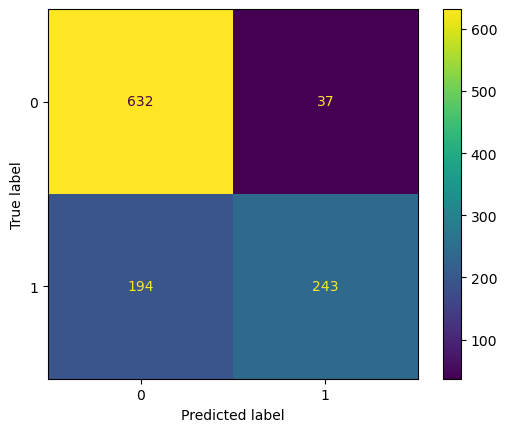

In [526]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_cvec, y_test);
plt.savefig('confusion1.png')
plt.show()

As expected this leads to a drop in our cross val score and a drop across all metrics, particularly the specificity (how good the model is at catching Midjourney subreddits).

As a last piece of EDA let's see if there is much difference in post length between the 2 subreddits

In [523]:
def length(str):
    try:
        return len(str)
    except:
        None

df['thread_length'] = df['all_text'].apply(length)

<AxesSubplot:xlabel='thread_length', ylabel='Count'>

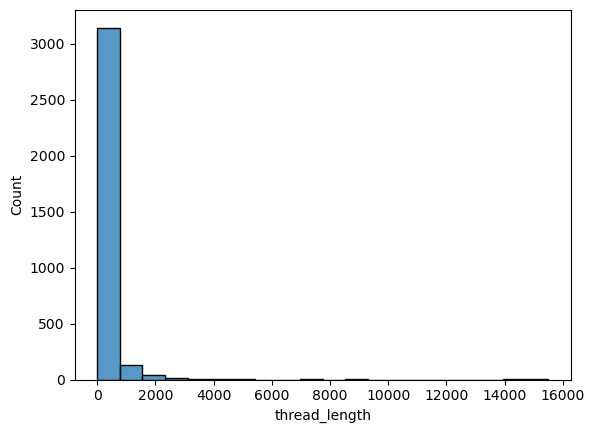

In [524]:
#This is the distribution of post length across 
sns.histplot(df['thread_length'], bins = 20)

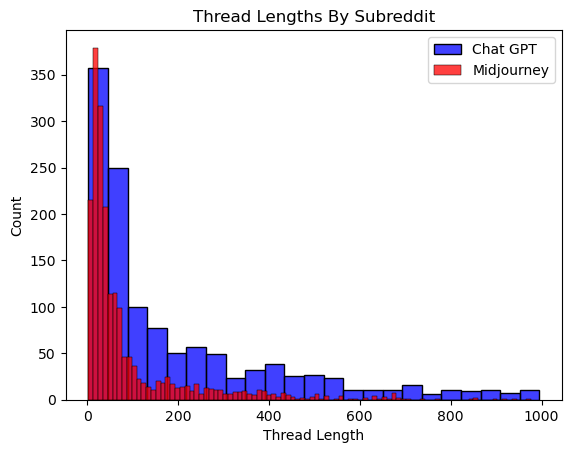

In [525]:
#Let's remove outliers above 1000 to get a better view of the distribution
df1 = df[df['thread_length'] < 1000]

df2 = df1[df1['subreddit'] == 1]
df3 = df1[df1['subreddit'] == 0]

sns.histplot(data=df2, x="thread_length", color="blue", label="Chat GPT")
sns.histplot(data=df3, x="thread_length", color="red", label="Midjourney")

plt.legend()

plt.savefig('thread_lengths.png')
plt.title('Thread Lengths By Subreddit')
plt.xlabel('Thread Length')
plt.show()


In [340]:
df2['thread_length'].mean(), df3['thread_length'].mean() 

(195.74545454545455, 90.68526897938662)

As we would expect, the posts for midjourney are considerably shorter and generally are limited to a short title. This likely has some impact in terms of the language, in that many of the titles are basically picture titles vs more in depth stack overflow style questions and discussions in ChatGPT.  

It also might explain why the model is good at identifying Midjourney subreddits, but far weaker at identifying ChatGPT subreddits.

## 3) Modelling

Now we have a more reasonable dataset, let's run hyperparameter optimized models using GridSearch. I am going to try logistic regression with Count Vectorizer and also TF-IDF. I am then going to choose the best model out of CVEC/TF-IDF and then try that with Naive Bayes, Random Forest, SVM and KNN.


First I am going to try an optimized LR model, using our amended stop words in the Count Vectorizer.
We use GridSearch to optimise hyperparameters across
- Max features, ie words in our feature list (eg we take the 500 most used words). 
- Minimum percentage of posts where the word has to feature (to remove extremely obscure words)
- Maximum percentage of posts where the word has to feature (to remove very common words with little value)
- N_gram range, ie here considering single words but also 'bigrams' ie combinations of 2 consecutive words

And for the Logistic Regression
- Solver - this is the algorithm in the optimisation problem. The defaults is lbfgs but I am also trying liblinear, which is recommended for high dimension datasets
- Penalty, which is regularisation, to reduce overfitting. Default is l2 (Ridge) but also trying Lasso and ElasticNet.
- C - this is regularisation strength, with small values relating to higher regularisation.


Not the reduction in our max features from ~7000 to sub 1000 is likely to reduce the model's performance but will also reduce overfitting.

Let's first build a score evaluation function which we will append to a list for comparability at the end. One of the most important metrics here is balanced accuracy, as this captures the trade off between specificity and sensitivity and in our case (as we are equally concerned about identifying both classes) is highly relevant. Also because we are dealing with an imbalanced dataset, accuracy can be rather misleading since the majority class here is being identified well (high specificity) but we care about the ability to identify the minority class just as much.

In [438]:
#Let's first build a score evaluation function which we will append to a list for comparability at the end

def overall_score(model, y_test, preds):
    
    train = model.score(X_train, y_train) 
    
    test = model.score(X_test, y_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    sensitivity = tp/(tp+fn)
    
    specificity = tn / (tn + fp) # this is also called recall
    
    precision = tp / (tp+ fp)
    
    f1 = 2* (precision * specificity) / (precision + specificity)
    
    bal_acc = (sensitivity + specificity)/2
    
    cv = cross_val_score (model, X_train, y_train, cv = 5).mean()
    
    print(f'Training score: {train}')
    print(f'Test score: {test}')  
    print(f'CrossVal: {cv}')  
    print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
    print(f"Sensitivity: {tp/(tp+fn)}")
    print(f"Specificity: {tn/(tn+fp)}")
    print(f"Precision: {precision}")
    print(f"Balanced Acc: {bal_acc}")
    print(f"f1: {f1}")
    
    return {
        'Training Score': train,
        'Test Score': test,
        'CV': {cv},
        'Sensitivity': tp/(tp+fn),
        'Specificity': tn/(tn+fp),
        'Precision': {precision},
        'Balanced Acc': {bal_acc},
        'f1': {f1}
    }


In [342]:
scores = []

In [343]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')),
    ('lr', LogisticRegression())
])



In [344]:
pipe1_params = {'cvec__max_features': [250, 500, 750],
              'cvec__min_df': [0.02, 0.05],
               'cvec__max_df': [0.9, 0.95],
               'cvec__ngram_range': [(1,1), (1,2)],
               'lr__solver': ['lbfgs', 'liblinear'], 
               'lr__penalty': ['l1', 'l2', 'elasticnet'],
               'lr__C': [0.01, 0.1, 1]
              }

In [345]:
gs1 = GridSearchCV(pipe1, 
                  param_grid=pipe1_params,
                  cv=5,
                  verbose=1) 

In [346]:
gs1.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [347]:
print(gs1.best_params_)

{'cvec__max_df': 0.9, 'cvec__max_features': 250, 'cvec__min_df': 0.02, 'cvec__ngram_range': (1, 1), 'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


In [348]:
gs1_model = gs1.best_estimator_

In [350]:
preds = gs1_model.predict(X_test)
scores.append(overall_score(gs1_model, y_test, preds))

Training score: 0.7219251336898396
Test score: 0.7043399638336347
CV: 0.7072293588927776
TN: 621
FP: 48
FN: 279
TP: 158
Sensitivity: 0.36155606407322655
Specificity: 0.9282511210762332
Precision: 0.7669902912621359
Balanced Acc: 0.6449035925747298
f1: 0.8399506908418511


In [351]:
scores

[{'Training Score': 0.7219251336898396,
  'Test Score': 0.7043399638336347,
  'CV': {0.7072293588927776},
  'Sensitivity': 0.36155606407322655,
  'Specificity': 0.9282511210762332,
  'Precision': {0.7669902912621359},
  'Balanced Acc': {0.6449035925747298},
  'f1': {0.8399506908418511}}]

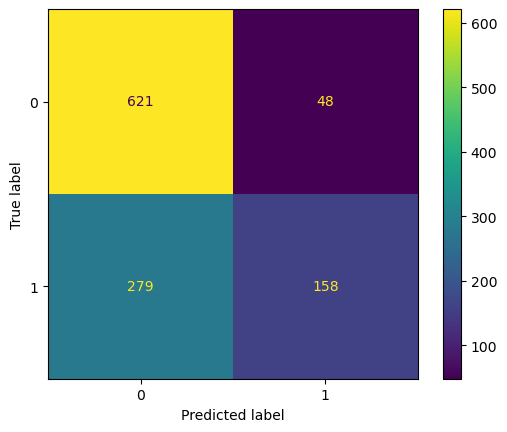

In [353]:
ConfusionMatrixDisplay.from_estimator(gs1_model, X_test, y_test);

We have seen a drop in score versus the original non optimised LR and this is largely due to the reduction in max features, which is reducing overfitting, but reducing the overall score. The model is still overfit though, and is poor at identifying ChatGPT subreddits (low sensitivity)

Let's also try TF-IDF as a word count vectorizer. This will give higher scores to words that occur relatively infrequently in the corpus but heavily in a particular document.


In [356]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')),
    ('lr', LogisticRegression()),
    
])

pipe2_params = {'tvec__max_features': [250, 500, 750],
              'tvec__min_df': [0.02, 0.05],
               'tvec__max_df': [0.9, 0.95],
               'tvec__ngram_range': [(1,1), (1,2)],
               'lr__solver': ['lbfgs', 'liblinear'], 
               'lr__penalty': ['l1', 'l2', 'elasticnet'],
               'lr__C': [0.01, 0.1, 1]
              }

gs2 = GridSearchCV(pipe2, 
                  param_grid=pipe2_params, 
                  cv=5,
                  verbose=1) 

gs2.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


In [357]:
print(gs2.best_score_)
print(gs2.best_params_)

0.7063315303849824
{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs', 'tvec__max_df': 0.9, 'tvec__max_features': 250, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 1)}


In [358]:
gs2_model = gs2.best_estimator_

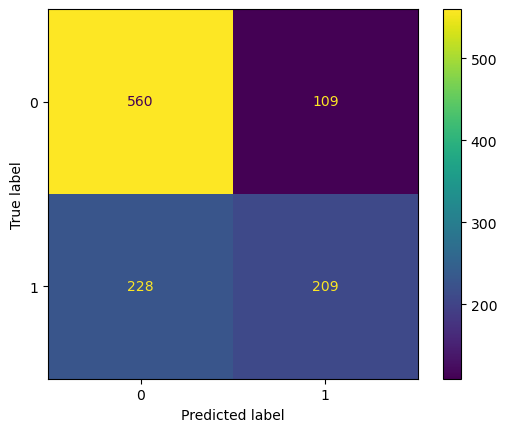

In [361]:
ConfusionMatrixDisplay.from_estimator(gs2_model, X_test, y_test);

In [363]:
preds = gs2_model.predict(X_test)
scores.append(overall_score(gs2_model, y_test, preds))

Training score: 0.7290552584670231
Test score: 0.6952983725135624
CV: 0.7063315303849824
TN: 560
FP: 109
FN: 228
TP: 209
Sensitivity: 0.4782608695652174
Specificity: 0.8370702541106129
Precision: 0.6572327044025157
Balanced Acc: 0.6576655618379151
f1: 0.7363298636997051


This is a slight improvement from count vectorizer in terms of balanced accuracy and sensitivity is much higher, ie it is better at identifying true cases of ChatGPT. We will therefore use TF-IDF going forward. 

### Multinomial Naive Bayes

Now we will try Multinomial Naive Bayes. We are using mutinomial which is well suited to frequencies of words in a document, rather than Bernoulli which is suited to binary features.  

In [364]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [365]:
pipe3 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')),
    ('mnb', MultinomialNB())
])

pipe3_params = {'tvec__max_features': [250, 500, 750],
              'tvec__min_df': [0.02, 0.05],
               'tvec__max_df': [0.9, 0.95],
               'tvec__ngram_range': [(1,1), (1,2)],
              }

gs3 = GridSearchCV(pipe3, 
                  param_grid=pipe3_params, 
                  cv=5,
                  verbose=1)

gs3.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [366]:
print(gs3.best_score_)
print(gs3.best_params_)

0.6684397868278715
{'tvec__max_df': 0.9, 'tvec__max_features': 250, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 2)}


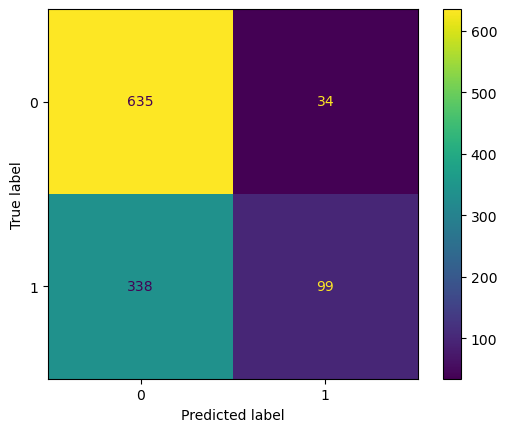

In [369]:
ConfusionMatrixDisplay.from_estimator(gs3_model, X_test, y_test);

In [371]:
preds = gs3_model.predict(X_test)
scores.append(overall_score(gs3_model, y_test, preds))

Training score: 0.6916221033868093
Test score: 0.6636528028933092
CV: 0.6684397868278715
TN: 635
FP: 34
FN: 338
TP: 99
Sensitivity: 0.22654462242562928
Specificity: 0.9491778774289985
Precision: 0.7443609022556391
Balanced Acc: 0.5878612499273139
f1: 0.8343840834583174


### Random Forest

In [372]:
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')),
    ('rf', RandomForestClassifier())
])

pipe4_params = {'tvec__max_features': [250, 500, 750],
              'tvec__min_df': [0.02, 0.05],
               'tvec__max_df': [0.9, 0.95],
               'tvec__ngram_range': [(1,1), (1,2)],
               'rf__n_estimators' : [50, 75, 100],
               'rf__max_depth' : [5,7,10],
               'rf__min_samples_leaf' : [3, 5, 8],
               'rf__min_samples_split' : [5, 7, 10]
                      }

gs4 = GridSearchCV(pipe4, 
                  param_grid=pipe4_params, 
                  cv=5,
                  verbose=1,
                  n_jobs = -1)

gs4.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


In [373]:
print(gs4.best_score_)
print(gs4.best_params_)

0.7183731705377029
{'rf__max_depth': 10, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 5, 'rf__n_estimators': 75, 'tvec__max_df': 0.95, 'tvec__max_features': 250, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 1)}


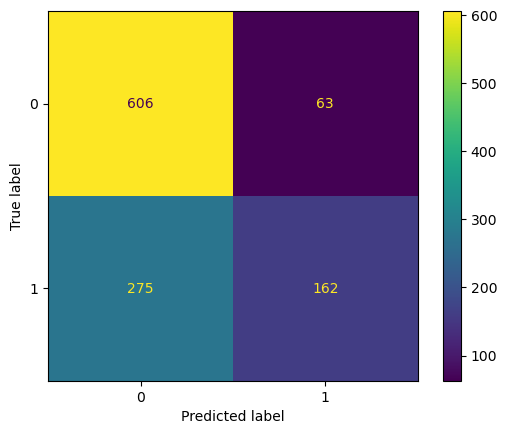

In [376]:
ConfusionMatrixDisplay.from_estimator(gs4_model, X_test, y_test);

In [378]:
preds = gs4_model.predict(X_test)
scores.append(overall_score(gs4_model, y_test, preds))

Training score: 0.7638146167557932
Test score: 0.6943942133815552
CV: 0.7085666560610882
TN: 606
FP: 63
FN: 275
TP: 162
Sensitivity: 0.3707093821510298
Specificity: 0.905829596412556
Precision: 0.72
Balanced Acc: 0.6382694892817928
f1: 0.8022947925860547


### Support Vector Machines

In [379]:
pipe5 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')),
    ('svc', SVC())
])

pipe5_params = {'tvec__max_features': [250, 500, 750],
              'tvec__min_df': [0.02, 0.05],
               'tvec__max_df': [0.9, 0.95],
               'tvec__ngram_range': [(1,1), (1,2)],
               'svc__kernel': ['rbf', 'poly', 'linear'],
               'svc__C': [10, 1, 0.1],
               'svc__gamma': [0.1, 1, 10]
                      }

gs5 = GridSearchCV(pipe5, 
                  param_grid=pipe5_params, 
                  cv=5,
                  verbose=1,
                  n_jobs = -1) 

gs5.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [380]:
print(gs5.best_score_)
print(gs5.best_params_)

0.7335079939548204
{'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf', 'tvec__max_df': 0.9, 'tvec__max_features': 250, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 1)}


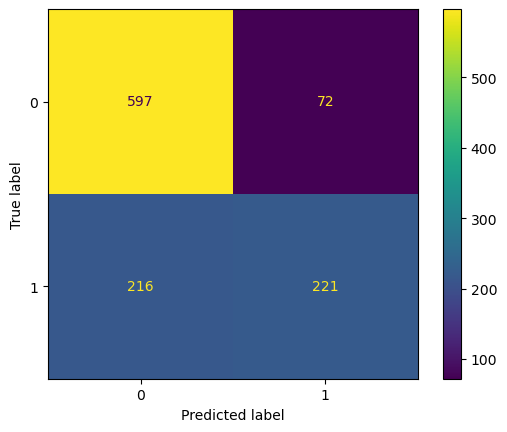

In [383]:
ConfusionMatrixDisplay.from_estimator(gs5_model, X_test, y_test);


In [385]:
preds = gs5_model.predict(X_test)
scores.append(overall_score(gs5_model, y_test, preds))

Training score: 0.8400178253119429
Test score: 0.7396021699819169
CV: 0.7335079939548204
TN: 597
FP: 72
FN: 216
TP: 221
Sensitivity: 0.505720823798627
Specificity: 0.8923766816143498
Precision: 0.7542662116040956
Balanced Acc: 0.6990487527064884
f1: 0.8175295101775258


### KNN

In [386]:
pipe6 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')),
    ('knn', KNeighborsClassifier())
])

pipe6_params = {'tvec__max_features': [250, 500, 750],
              'tvec__min_df': [0.02, 0.05],
               'tvec__max_df': [0.9, 0.95],
               'tvec__ngram_range': [(1,1), (1,2)],
               'knn__n_neighbors': [3, 5, 7, 10, 20]
                      }

gs6 = GridSearchCV(pipe6,
                  param_grid=pipe6_params,
                  cv=5,
                  verbose=1,
                  n_jobs = -1) 

gs6.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

In [387]:
print(gs6.best_score_)
print(gs6.best_params_)

0.6871639357301941
{'knn__n_neighbors': 5, 'tvec__max_df': 0.9, 'tvec__max_features': 250, 'tvec__min_df': 0.02, 'tvec__ngram_range': (1, 2)}


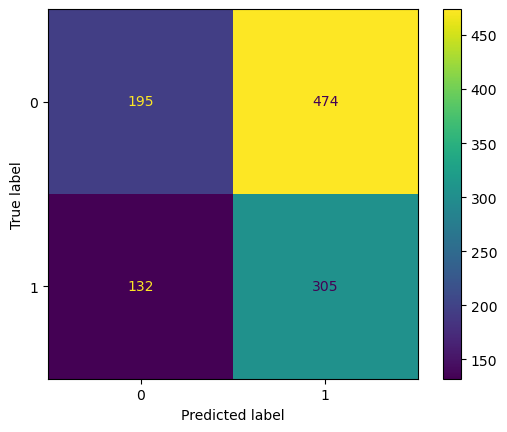

In [390]:
ConfusionMatrixDisplay.from_estimator(gs6_model, X_test, y_test);

In [392]:
preds = gs6_model.predict(X_test)
scores.append(overall_score(gs6_model, y_test, preds))

Training score: 0.5231729055258467
Test score: 0.45207956600361665
CV: 0.6871639357301941
TN: 195
FP: 474
FN: 132
TP: 305
Sensitivity: 0.6979405034324943
Specificity: 0.2914798206278027
Precision: 0.39152759948652116
Balanced Acc: 0.4947101620301485
f1: 0.33417614833544035


In [393]:
pd.DataFrame(scores, index= ['LR_cvec', 'LR_tvec', 'NB_tvec', 'RF_tvec', 'SVM_tvec', 'KNN_tvec'])

,Training Score,Test Score,CV,Sensitivity,Specificity,Precision,Balanced Acc,f1
LR_cvec,0.721925,0.704340,{0.7072293588927776},0.361556,0.928251,{0.7669902912621359},{0.6449035925747298},{0.8399506908418511}
LR_tvec,0.729055,0.695298,{0.7063315303849824},0.478261,0.837070,{0.6572327044025157},{0.6576655618379151},{0.7363298636997051}
NB_tvec,0.691622,0.663653,{0.6684397868278715},0.226545,0.949178,{0.7443609022556391},{0.5878612499273139},{0.8343840834583174}
RF_tvec,0.763815,0.694394,{0.7085666560610882},0.370709,0.905830,{0.72},{0.6382694892817928},{0.8022947925860547}
SVM_tvec,0.840018,0.739602,{0.7335079939548204},0.505721,0.892377,{0.7542662116040956},{0.6990487527064884},{0.8175295101775258}
KNN_tvec,0.523173,0.452080,{0.6871639357301941},0.697941,0.291480,{0.39152759948652116},{0.4947101620301485},{0.33417614833544035}


From the above table, we can see that across the various models a consistent theme is that (aside for knn) the models are relatively weak at identifying ChatGPT, ie specificity is low, but that the model does well with Midjourney. This may in part be due to the higher weighting of Midjourney posts (60% of the dataset) but it is also likely due to the more specific language used, since Midjourney posts are generally much shorter and are generally relating to the artwork produced, with a catchy art like title. So the language is far more predictive.

As the model is much better at predicting the majority class, accuracy scores are somewhat misleading since this will reward correct identification of the majority class over the minority. We need to consider sensitivity in the evaluation. As such, balanced accuracy is a good measure (sensitivity + specificity)/2. On this basis, SVM appears to be the strongest model, with much higher specificity and comparable sensitivity to the best models, and as such the highest test and cross-validation score.

Let's also try adjusting the prediction threshold. We can do this with a custom scorer function which then becomes a parameter in GridSearch. I found that using a selection of parameters caused problems for some of the hyperparameters in logistic regression. Also for most models I was receiving slightly worse scores than under the original non-adjusted cutoff data. Here is SVM with a 25% cutoff ie anything above 25% probability is deemed to be a 1, ie ChatGPT. Performance was much worse.

In [533]:

from sklearn.metrics import make_scorer, recall_score

def custom_recall(y_true, y_pred_prob):
    threshold = 0.25  
    
    if y_pred_prob.ndim == 1:
        y_pred = np.where(y_pred_prob > threshold, 1, 0)
    else:
        y_pred = np.where(y_pred_prob[:, 1] > threshold, 1, 0)
    return recall_score(y_true, y_pred)


custom_scorer = make_scorer(custom_recall, needs_proba=True)


In [534]:



pipe7 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=new_stops,token_pattern=r'\b[a-zA-Z]+\b')),
    ('svc', SVC(probability=True))
])

pipe7_params = {'tvec__max_features': [250, 500, 750],
              'tvec__min_df': [0.02, 0.05],
               'tvec__max_df': [0.9, 0.95],
               'tvec__ngram_range': [(1,1), (1,2)],
               'svc__kernel': ['rbf', 'poly', 'linear'],
               'svc__C': [10, 1, 0.1],
               'svc__gamma': [0.1, 1, 10]
                      }

gs7 = GridSearchCV(pipe7, 
                  param_grid=pipe7_params, 
                  cv=5,
                  verbose=0,
                  scoring=custom_scorer,
                  n_jobs = -1) 

gs7.fit(X_train, y_train)

import warnings
warnings.filterwarnings('ignore')

gs7_model = gs7.best_estimator_


preds = gs7_model.predict(X_test)
overall_score(gs7_model, y_test, preds)


Training score: 0.6042780748663101
Test score: 0.604882459312839
CrossVal: 0.6042783566656061
TN: 669
FP: 0
FN: 437
TP: 0
Sensitivity: 0.0
Specificity: 1.0
Precision: nan
Balanced Acc: 0.5
f1: nan


{'Training Score': 0.6042780748663101,
 'Test Score': 0.604882459312839,
 'CV': {0.6042783566656061},
 'Sensitivity': 0.0,
 'Specificity': 1.0,
 'Precision': {nan},
 'Balanced Acc': {0.5},
 'f1': {nan}}

#### Overall then we can predict the subclass with a roughly 74% accuracy and 70% balanced accuracy using SVM, even after removing high signal feature words. This compares to our baseline of 60.4%, so the model is doing significantly better than random guessing.

#### In future work I would like to conduct further work on this weak identification of the ChatGPT class and would consider oversampling techniques as a good place to start.